# Setting

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [2]:
%ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3001           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      22146           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5120            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        404           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       2082            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       6801   

In [4]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 55.6MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 60.9MB/s]


In [16]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# **Data Analysis**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [78]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(test)

         id  ...                                                                                                                                         text
0     0      ...  Just happened a terrible car crash                                                                                                         
1     2      ...  Heard about #earthquake is different cities, stay safe everyone.                                                                           
2     3      ...  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all                                           
3     9      ...  Apocalypse lighting. #Spokane #wildfires                                                                                                   
4     11     ...  Typhoon Soudelor kills 28 in China and Taiwan                                                                                              
...   ..     ...                                    

#### Data Cleaning

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### train과 test set에서 URL, html, 구두점을 삭제한다.

In [9]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

## GloVe
##### Word2Vec: 기준 단어의 앞/뒤 단어들의 평균 임베딩 벡터인 Context vector와 기준 단어의 임베딩 벡터가 가깝도록 만든다. 동시에 co-occurrene가 높은 단어들이 비슷한 임베딩 벡터를 지니도록 학습한다.

GloVe: co-occurence가 있는 두 단어의 임베딩 벡터를 이용해서 co-occurrence값을 예측하는 regression 문제를 풀도록 한다.  따라서 co-occurrence가 높을수록 두 단어 벡터가 비슷해지도록 만든다. 


[참조한 블로그](https://lovit.github.io/nlp/representation/2018/09/05/glove/)

In [0]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

##### corpus: 각 데이터를 단어로만 이루어진 list로 만든다.

In [14]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7278.60it/s]


##### Use GloVe pretrained corpus model
##### 이미 만들어진 임베딩 벡터를 통해서 예측하자

In [0]:
fname = '/content/gdrive/My Drive/Data Mining Project/glove_twitter/glove.twitter.27B.100d.txt'
# 200d / 25d / 50d

In [0]:
# 3 varieties: 50D, 100D, 200Dimentional

embedding_dict={}
with open(fname,'r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [27]:
print('Loaded %s word vectors.' % len(embedding_dict))

Loaded 1193514 word vectors.


##### fit_on_texts: text를 컴퓨터가 이해할 수 있는 숫자 데이터로 바꾼다. word index를 생성

texts_to_sequences: index를 sequence로 변환

pad_sequence: 길이가 다른 문장들을 모두 MAX_LEN에 맞춘다

[참조](https://inspiringpeople.github.io/data%20analysis/Glove/)

In [0]:
MAX_LEN=50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [26]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


##### 해당 embedding vector로 데이터를 대체

In [28]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

embedding = Embedding(num_words, 100, embeddings_initializer = Constant(embedding_matrix),
                      input_length = MAX_LEN, trainable = False)

100%|██████████| 20342/20342 [00:00<00:00, 213657.60it/s]


##### Embedding된 단어 예시

In [0]:
def cos_sim(u,v):
    """
    u: vector of 1st word
    v: vector of 2nd Word
    """
    numerator_ = u.dot(v)
    denominator_= np.sqrt(np.sum(np.square(u))) * np.sqrt(np.sum(np.square(v)))
    return numerator_/denominator_

In [32]:
all_words = embedding_dict.keys()

print("Similarity Score of Cat and Dog",cos_sim(embedding_dict['cat'],embedding_dict['dog']))
print("Similarity Score of Student and Cake",cos_sim(embedding_dict['student'],embedding_dict['cake']))
print("Similarity Score of Cat and Baby",cos_sim(embedding_dict['cat'],embedding_dict['baby']))
print("Similarity Score of Mother and daughter",cos_sim(embedding_dict['mother'],embedding_dict['daughter']))

Similarity Score of Cat and Dog 0.87520885
Similarity Score of Student and Cake 0.26368493
Similarity Score of Cat and Baby 0.64463943
Similarity Score of Mother and daughter 0.8259466


### Visualization of Word Embedding

연관성 높은 단어가 가까이 존재하는 지를 볼 수 있다.

##### PCA

고차원에서 저차원으로 mapping하는 데, 정보가 가장 잘 보존되도록 한다.

In [0]:
def return_matrix(random_words, dim =100):
    word_matrix = np.random.randn(len(random_words), dim)
    i = 0
    for word in random_words:
        word_matrix[i] = embedding_dict.get(word)
        i +=1
    return word_matrix

(-5.0, 6.0)

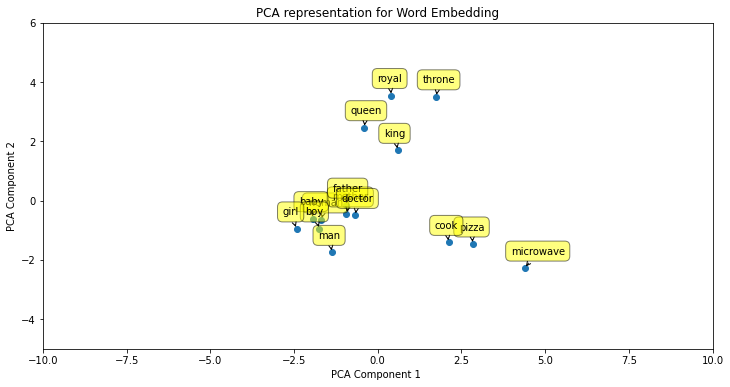

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

random_words = ['man','woman','king','queen','microwave','baby','boy','girl','pizza','royal','mother','father','doctor','cook','throne']
return_matrix_ = return_matrix(random_words)

# 100차원 데이터를 적절하게 2차원에서 표현한다.
pca_ = PCA(n_components=2)
viz_data = pca_.fit_transform(return_matrix_) 

plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(random_words,viz_data[:,0],viz_data[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('PCA Component 1 ')
plt.ylabel('PCA Component 2')
plt.title('PCA representation for Word Embedding')
plt.xlim(-10,10)
plt.ylim(-5,6)

##### T-SNE

점들 간 유사도를 보존하면서 차원을 축소한다.

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 1.779327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.922796
[t-SNE] KL divergence after 1000 iterations: 0.166903


Text(0.5, 1.0, 'TSNE representation for Word Embedding')

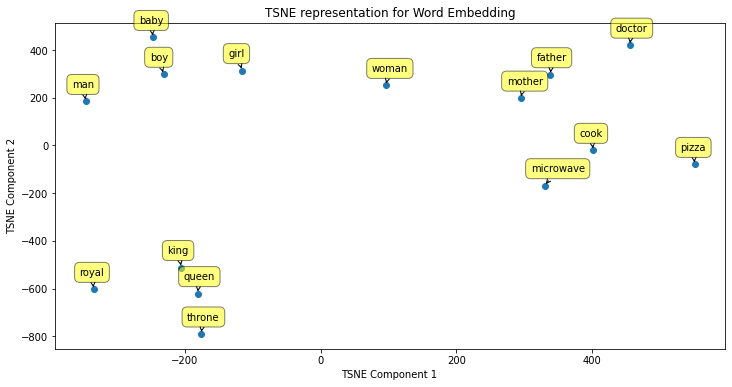

In [45]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=3, method='exact')
tsne_results = tsne.fit_transform(return_matrix_)

plt.scatter(tsne_results[:,0],tsne_results[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(random_words,tsne_results[:,0],tsne_results[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('TSNE Component 1 ')
plt.ylabel('TSNE Component 2')
plt.title('TSNE representation for Word Embedding')


##### Analogy

잘 안 됨...

In [0]:
def find_w4(word1,word2,word3, w2v):
    """
    """
    word_list = w2v.keys()
    max_sim = -1000
    #Make Sure they are lower
    word1,word2,word3 = word1.lower(), word2.lower(), word3.lower()
    
    word1v = w2v.get(word1)
    word2v = w2v.get(word2)
    word3v = w2v.get(word3)
    
    diff_vec = word3v - ( word1v - word2v ) #word3 - (word1 - word2)

    for word in word_list:
        vec = w2v.get(word)

        if vec.shape[0] != 100:
            continue

        sim_ = cos_sim(u=diff_vec, v=vec)

        if word == 'woman' or word == 'man':
            print(word)
            print(diff_vec)
            print(sim_, vec)

        if sim_ > max_sim:
            max_sim = sim_
            word_selected =  word

    print(max_sim)        
    return word_selected

In [0]:
print("King is to Queen as Man is to ",find_w4('king','queen','man',embedding_dict))
print("Cook is to Pizza as Doctor is to ",find_w4('cook','pizza','doctor',embedding_dict))
print("India is to Delhi as Japan is to ",find_w4('india','delhi','japan',embedding_dict))
print("kid is to toy as doctor is to ",find_w4('kid','toy','doctor',embedding_dict))

##### Model

In [0]:
train_data=tweet_pad[:train.shape[0]]
test_data=tweet_pad[train.shape[0]:]

In [0]:
model=Sequential()
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

##### 문장을 word index sequence로 표현하여 데이터 구성 (50)

-> GloVe로 만들어진 embedding을 통해서 sequence를 embedding

-> dropout 후 LSTM

-> LSTM의 마지막 output을 가지고 Fully Connected Layer

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [64]:
X_train,X_test,y_train,y_test=train_test_split(train_data,train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [66]:
history=model.fit(X_train,y_train,batch_size=4,epochs=50,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/50
 - 39s - loss: 0.5243 - accuracy: 0.7687 - val_loss: 0.5013 - val_accuracy: 0.7846
Epoch 2/50
 - 39s - loss: 0.5232 - accuracy: 0.7696 - val_loss: 0.4998 - val_accuracy: 0.7863
Epoch 3/50
 - 39s - loss: 0.5207 - accuracy: 0.7671 - val_loss: 0.4996 - val_accuracy: 0.7837
Epoch 4/50
 - 39s - loss: 0.5256 - accuracy: 0.7659 - val_loss: 0.4983 - val_accuracy: 0.7855
Epoch 5/50
 - 39s - loss: 0.5193 - accuracy: 0.7719 - val_loss: 0.4988 - val_accuracy: 0.7837
Epoch 6/50
 - 39s - loss: 0.5248 - accuracy: 0.7713 - val_loss: 0.4977 - val_accuracy: 0.7846
Epoch 7/50
 - 39s - loss: 0.5190 - accuracy: 0.7690 - val_loss: 0.4989 - val_accuracy: 0.7820
Epoch 8/50
 - 39s - loss: 0.5121 - accuracy: 0.7807 - val_loss: 0.4983 - val_accuracy: 0.7828
Epoch 9/50
 - 39s - loss: 0.5194 - accuracy: 0.7719 - val_loss: 0.4967 - val_accuracy: 0.7872
Epoch 10/50
 - 39s - loss: 0.5130 - accuracy: 0.7761 - val_loss: 0.4938 - val_accuracy: 0.7872
Epoch 11/50

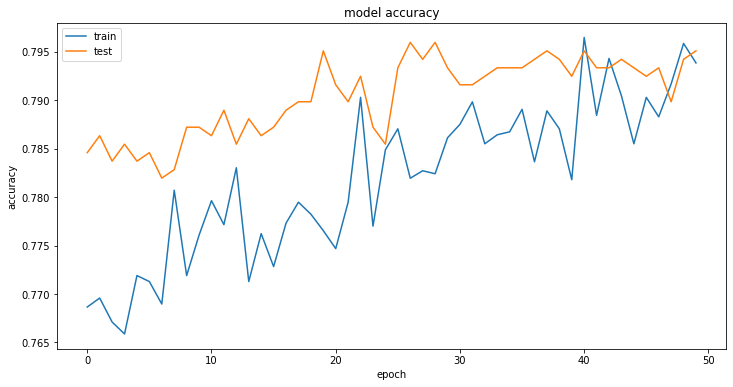

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission

In [0]:
sample_sub=pd.read_csv('./sample_submission.csv')

In [0]:
y_pre = model.predict(test_data)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [82]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
!cp './submission.csv' '/content/gdrive/My Drive/Data Mining Project/GloVe_submission.csv'